# Best Neighborhood in Pittsburgh – Final Report

This notebook presents the final combined analysis for our Big Idea final project.

Our goal is to answer the question:

> **Which neighborhood in Pittsburgh is the "best" according to our data-driven metric?**

We focus on everyday, lived-experience aspects of neighborhoods that are:
- **Clean and convenient** to use public trash containers,
- **Not too painful to park in**, and
- **Comfortable and interesting to walk through**, especially in terms of city steps.

To do this, our team (Procrastinateam) defined three sub-metrics:

1. **Smart Trash Score (`trash_score`)**
   Density of smart trash containers per neighborhood, representing cleanliness and convenience.

2. **Parking Score (`parking_score`)**
   A reverse of a "parking pain" index based on the number of parking points and their hourly costs.
   Higher values mean **less parking pain** (easier and/or cheaper parking).

3. **City Steps Score (`compact_stair_score`)**
   A measure of how rich and compact the city steps network is in each neighborhood, capturing a vertical walkability dimension.

In this final notebook, we:
- Load each processed metric,
- Merge them by neighborhood,
- Combine them into a single **Bestness Score**,
- Rank all neighborhoods, and
- Visualize the results using both bar charts and a choropleth map.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import geopandas as gpd
    GEOPANDAS_AVAILABLE = True
except ImportError:
    GEOPANDAS_AVAILABLE = False
    print("GeoPandas is not available in this environment. Map plots will be skipped.")

## 1. Loading processed metric tables

Each team member produced a cleaned and aggregated CSV for their sub-metric:

- `smart_trash_metric_by_hood.csv` with `trash_score`
- `parking_scores.csv` with `parking_score`
- `steps_scores.csv` with `compact_stair_score` (among other columns)

All of these files live in `data/processed/`.

We now load these tables and select only the columns we need for the combined metric.

In [4]:
trash = pd.read_csv("../data/processed/smart_trash_metric_by_hood.csv")
parking = pd.read_csv("../data/processed/parking_scores.csv")
steps = pd.read_csv("../data/processed/steps_scores.csv")

print("Trash metric columns:", list(trash.columns))
print("Parking metric columns:", list(parking.columns))
print("Steps metric columns:", list(steps.columns))

trash.head()

Trash metric columns: ['hood', 'area_sqmiles', 'trash_count', 'trash_per_sqmi', 'trash_score']
Parking metric columns: ['hood', 'meter_count', 'avg_rate', 'pain_raw', 'pain_log', 'pain_norm', 'parking_score']
Steps metric columns: ['neighborhood', 'total_steps', 'stair_count', 'sqmiles', 'steps_density', 'stairs_density', 'steps_density_norm', 'stairs_density_norm', 'avg_steps_per_stair', 'avg_steps_per_stair_norm', 'short_stair_score', 'compact_stair_score']


,hood,area_sqmiles,trash_count,trash_per_sqmi,trash_score
0,Allegheny Center,0.208937,7.0,33.502951,0.187758
1,Allegheny West,0.144794,15.0,103.595238,0.580569
2,Allentown,0.296998,9.0,30.303207,0.169825
3,Arlington,0.479975,3.0,6.250319,0.035028
4,Arlington Heights,0.127234,0.0,0.000000,0.000000


## 2. Building a unified neighborhood table

Before we can define a single "Bestness" score, we need a unified table where each row
represents a neighborhood and the columns contain:

- `trash_score` – smart trash density score
- `parking_score` – reverse parking pain score
- `compact_stair_score` – city steps compactness score

There are a few preparation steps:

1. **Rename** the steps table column `neighborhood` to `hood` so all tables use the same key.
2. **Select** only the columns required for the combined metric.
3. **Merge** the three tables on the neighborhood key `hood`.

We also create a `steps_score` column equal to `compact_stair_score`, so that our final
formula has a consistent name.

In [5]:
steps_renamed = steps.rename(columns={"neighborhood": "hood"})

trash_small = trash[["hood", "trash_score"]].copy()
parking_small = parking[["hood", "parking_score"]].copy()
steps_small = steps_renamed[["hood", "compact_stair_score"]].copy()

best_df = (
    trash_small
    .merge(parking_small, on="hood", how="outer")
    .merge(steps_small, on="hood", how="outer")
)

best_df["steps_score"] = best_df["compact_stair_score"]

best_df.head()

,hood,trash_score,parking_score,compact_stair_score,steps_score
0,Allegheny Center,0.187758,0.408040,0.221073,0.221073
1,Allegheny West,0.580569,0.487878,0.164628,0.164628
2,Allentown,0.169825,0.844700,0.499831,0.499831
3,Arlington,0.035028,NaN,0.182324,0.182324
4,Arlington Heights,0.000000,NaN,NaN,NaN


## 3. Defining the combined Bestness Score

Each of our sub-metrics has been normalized to lie between 0 and 1, where higher values
mean "better" for that dimension. We combine them into a single **Bestness Score** using
a weighted average:

- **Smart Trash Score** (`trash_score`) – weight **0.25**
- **Parking Score** (`parking_score`) – weight **0.40**
- **Steps Score** (`steps_score` = `compact_stair_score`) – weight **0.35**

Formally, for each neighborhood:

\[
\text{Bestness} =
0.25 \cdot \text{trash\_score} +
0.40 \cdot \text{parking\_score} +
0.35 \cdot \text{steps\_score}
\]

We interpret these weights as follows:

- Parking has the largest weight (0.40), reflecting that parking difficulty can have
  a major impact on daily life.
- City steps / vertical walkability are also very important (0.35), capturing how
  interesting and walkable a neighborhood feels.
- Smart trash coverage (0.25) captures cleanliness and convenience, which are important
  but slightly less critical than parking and mobility in our view.

To avoid artifacts from missing data, we restrict our ranking to neighborhoods that have
non-missing values for all three sub-metrics.

In [6]:
required_cols = ["trash_score", "parking_score", "steps_score"]
best_df_clean = best_df.dropna(subset=required_cols).copy()

print(f"Total neighborhoods before filtering: {len(best_df)}")
print(f"Total neighborhoods after filtering:  {len(best_df_clean)}")

w_trash = 0.25
w_parking = 0.40
w_steps = 0.35

assert abs(w_trash + w_parking + w_steps - 1.0) < 1e-6, "Weights must sum to 1."

best_df_clean["best_score"] = (
    w_trash   * best_df_clean["trash_score"] +
    w_parking * best_df_clean["parking_score"] +
    w_steps   * best_df_clean["steps_score"]
)

best_df_clean.head()

Total neighborhoods before filtering: 90
Total neighborhoods after filtering:  36


,hood,trash_score,parking_score,compact_stair_score,steps_score,best_score
0,Allegheny Center,0.187758,0.408040,0.221073,0.221073,0.287531
1,Allegheny West,0.580569,0.487878,0.164628,0.164628,0.397913
2,Allentown,0.169825,0.844700,0.499831,0.499831,0.555277
7,Beechview,0.030725,0.691779,0.142445,0.142445,0.334249
9,Bloomfield,0.463072,0.292356,0.070892,0.070892,0.257522


## 4. Ranking neighborhoods by Bestness

With the combined `best_score` computed, we can now sort neighborhoods from highest
to lowest score and identify:

- The **overall best neighborhood** according to our metric,
- The **top 5–10 neighborhoods**, and
- Any surprising "underdogs" that perform well or badly compared to our expectations.

Below we start by sorting and printing the top 10 neighborhoods by `best_score`.

In [7]:
best_df_ranked = best_df_clean.sort_values("best_score", ascending=False).reset_index(drop=True)
top10 = best_df_ranked.head(10)
top10

,hood,trash_score,parking_score,compact_stair_score,steps_score,best_score
0,Allentown,0.169825,0.844700,0.499831,0.499831,0.555277
1,Upper Lawrenceville,0.208132,1.000000,0.141001,0.141001,0.501384
2,Brighton Heights,0.120410,1.000000,0.074648,0.074648,0.456229
3,Duquesne Heights,0.027137,0.867257,0.253378,0.253378,0.442369
4,Perry North,0.069479,0.867257,0.221853,0.221853,0.441921
5,Greenfield,0.101311,0.760086,0.321573,0.321573,0.441913
6,Lower Lawrenceville,0.378007,0.590160,0.285086,0.285086,0.430346
7,East Allegheny,0.620263,0.627342,0.041457,0.041457,0.420513
8,West End,0.259233,0.734513,0.140391,0.140391,0.407750
9,Knoxville,0.130929,0.760086,0.197344,0.197344,0.405837


## 5. Visualizing the Bestness Score

To better understand the ranking, we visualize:

1. A **horizontal bar chart** of the top 10 neighborhoods by `best_score`.
2. (Optionally) Separate bar charts for each sub-metric to see how different
   neighborhoods specialize in trash, parking, or steps.

Here we start with the top 10 Bestness scores.

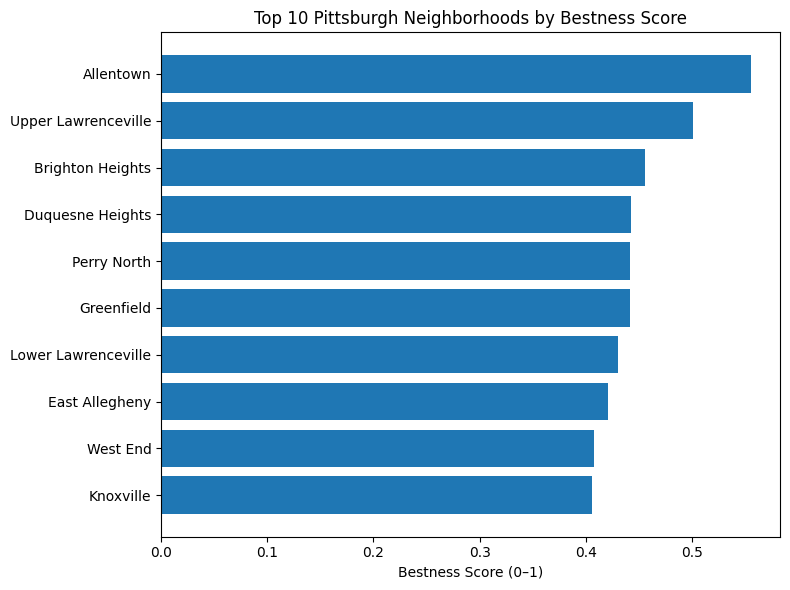

In [8]:
top10_plot = top10.sort_values("best_score", ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(top10_plot["hood"], top10_plot["best_score"])
plt.xlabel("Bestness Score (0–1)")
plt.title("Top 10 Pittsburgh Neighborhoods by Bestness Score")
plt.tight_layout()
plt.show()

In [9]:
top10_metrics = top10[["hood", "trash_score", "parking_score", "steps_score"]].set_index("hood")
top10_metrics

,trash_score,parking_score,steps_score
hood,,,
Allentown,0.169825,0.844700,0.499831
Upper Lawrenceville,0.208132,1.000000,0.141001
Brighton Heights,0.120410,1.000000,0.074648
Duquesne Heights,0.027137,0.867257,0.253378
Perry North,0.069479,0.867257,0.221853
Greenfield,0.101311,0.760086,0.321573
Lower Lawrenceville,0.378007,0.590160,0.285086
East Allegheny,0.620263,0.627342,0.041457
West End,0.259233,0.734513,0.140391


## 6. Mapping Bestness across Pittsburgh

To show the spatial pattern of our metric, we join the Bestness scores with the official
Pittsburgh neighborhood boundaries shapefile and draw a choropleth map.

We use:

- `Neighborhoods_.shp` located in `data/raw/`
- The `hood` column in the shapefile, which matches the neighborhood names in our tables

Columns in shapefile: ['OBJECTID', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10', 'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10', 'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng', 'fid_neighb', 'perimeter', 'neighbor_', 'neighbor_i', 'hood', 'hood_no', 'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1', 'shape_ar_1', 'page_numbe', 'plannerass', 'created_us', 'created_da', 'last_edite', 'last_edi_1', 'temp', 'pghdb_sde_', 'GlobalID', 'Shape__Are', 'Shape__Len', 'geometry']


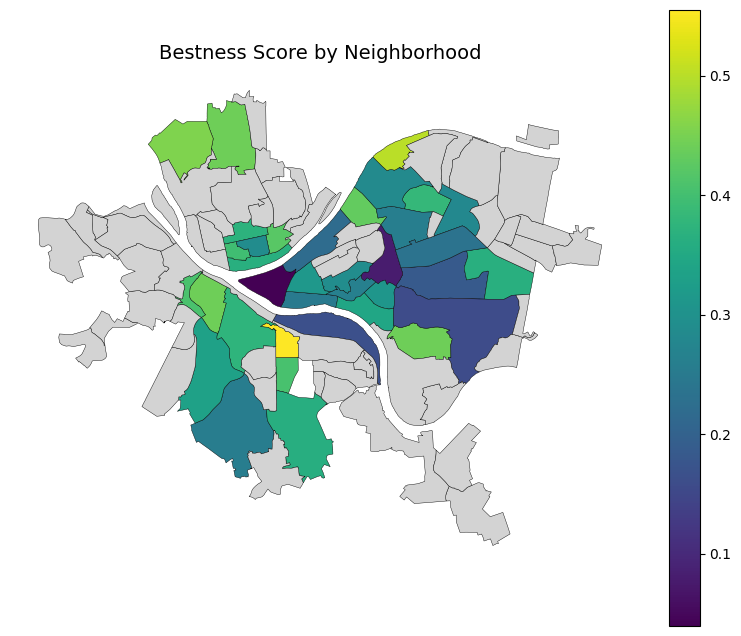

In [10]:
if GEOPANDAS_AVAILABLE:
    neighborhoods_shp = "../data/raw/Neighborhoods_.shp"
    neigh_gdf = gpd.read_file(neighborhoods_shp)

    print("Columns in shapefile:", list(neigh_gdf.columns))

    if "hood" not in neigh_gdf.columns:
        raise ValueError("Shapefile does not contain a 'hood' column. Please adjust the merge key.")

    neigh_best = neigh_gdf.merge(
        best_df_clean[["hood", "best_score"]],
        on="hood",
        how="left"
    )

    ax = neigh_best.plot(
        column="best_score",
        legend=True,
        figsize=(10, 8),
        edgecolor="black",
        linewidth=0.3,
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        }
    )
    ax.set_axis_off()
    ax.set_title("Bestness Score by Neighborhood", fontsize=14)
else:
    print("GeoPandas is not available – skipping the map.")

### 6b. Imputing missing parking scores

The parking dataset only covers a subset of Pittsburgh neighborhoods, which means many
neighborhoods have `NaN` values for `parking_score`. On the map above, these show up
as gray polygons.

To avoid treating these neighborhoods as if they had "no parking" at all, we make a
simple imputation choice:

> For neighborhoods without parking data, we assign the **mean parking score** of all
> neighborhoods that do have observed parking data.

This has a few properties:

- It keeps the parking dimension from unfairly penalizing neighborhoods that simply
  lack meter data.
- It still allows neighborhoods with very good or very bad parking scores to stand out.
- It makes the combined Bestness score defined for a larger set of neighborhoods.

Below we:
1. Compute the mean `parking_score` over all neighborhoods with observed data.
2. Fill missing `parking_score` values with that mean.
3. Recompute a new combined **Bestness (imputed)** score.
4. Rank neighborhoods again and redraw the choropleth map with the imputed scores.

In [11]:
mean_parking_score = best_df["parking_score"].mean(skipna=True)
print("Mean parking_score used for imputation:", mean_parking_score)

best_df_imputed = best_df.copy()

best_df_imputed["parking_score_filled"] = best_df_imputed["parking_score"].fillna(mean_parking_score)

best_df_imputed["steps_score"] = best_df_imputed["compact_stair_score"]

required_cols_imputed = ["trash_score", "steps_score"]
best_df_imputed_clean = best_df_imputed.dropna(subset=required_cols_imputed).copy()

print(f"Neighborhoods after imputation (still requiring trash & steps): {len(best_df_imputed_clean)}")

best_df_imputed_clean["best_score_imputed"] = (
    w_trash   * best_df_imputed_clean["trash_score"] +
    w_parking * best_df_imputed_clean["parking_score_filled"] +
    w_steps   * best_df_imputed_clean["steps_score"]
)

best_df_imputed_ranked = best_df_imputed_clean.sort_values(
    "best_score_imputed", ascending=False
).reset_index(drop=True)

best_df_imputed_ranked.head(10)

Mean parking_score used for imputation: 0.561286449131579
Neighborhoods after imputation (still requiring trash & steps): 79


,hood,trash_score,parking_score,compact_stair_score,steps_score,parking_score_filled,best_score_imputed
0,Allentown,0.169825,0.844700,0.499831,0.499831,0.844700,0.555277
1,Upper Lawrenceville,0.208132,1.000000,0.141001,0.141001,1.000000,0.501384
2,South Side Slopes,0.062005,NaN,0.737204,0.737204,0.561286,0.498037
3,Brighton Heights,0.120410,1.000000,0.074648,0.074648,1.000000,0.456229
4,Polish Hill,0.284406,NaN,0.447348,0.447348,0.561286,0.452188
5,Duquesne Heights,0.027137,0.867257,0.253378,0.253378,0.867257,0.442369
6,Perry North,0.069479,0.867257,0.221853,0.221853,0.867257,0.441921
7,Greenfield,0.101311,0.760086,0.321573,0.321573,0.760086,0.441913
8,Middle Hill,0.532614,NaN,0.223717,0.223717,0.561286,0.435969
9,Lower Lawrenceville,0.378007,0.590160,0.285086,0.285086,0.590160,0.430346


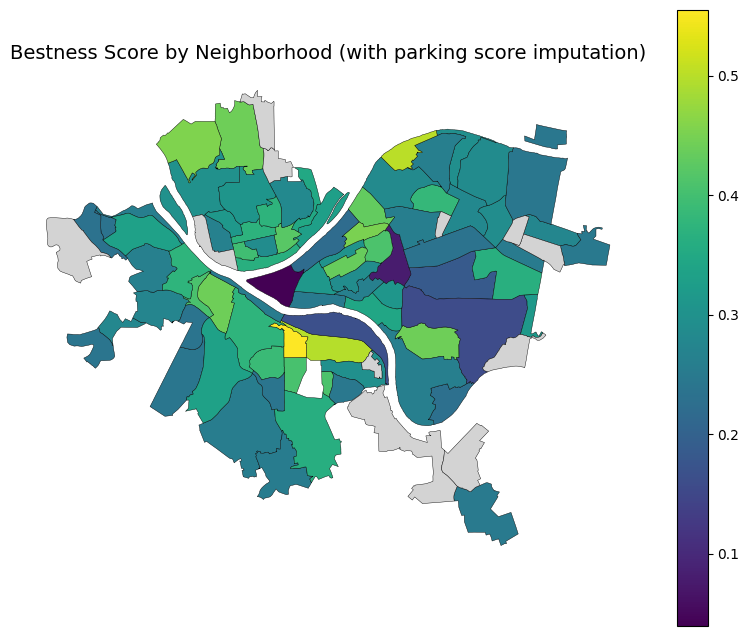

In [12]:
if GEOPANDAS_AVAILABLE:
    neigh_best_imputed = neigh_gdf.merge(
        best_df_imputed_clean[["hood", "best_score_imputed"]],
        on="hood",
        how="left"
    )

    ax = neigh_best_imputed.plot(
        column="best_score_imputed",
        legend=True,
        figsize=(10, 8),
        edgecolor="black",
        linewidth=0.3,
        missing_kwds={
            "color": "lightgrey",
            "label": "No data"
        }
    )
    ax.set_axis_off()
    ax.set_title("Bestness Score by Neighborhood (with parking score imputation)", fontsize=14)
else:
    print("GeoPandas is not available – skipping the imputed map.")

## 7. Discussion of Results and Limitations (Condensed)

### 7.1 Bestness Ranking Patterns
Our combined Bestness score highlights neighborhoods that balance **smart trash**, **parking**, and **city steps**.
**Allentown** ranks first, with strong parking and solid steps; **Upper Lawrenceville** follows due to excellent parking and good trash coverage. Other high performers like **Brighton Heights**, **Duquesne Heights**, and **Perry North** succeed through different mixes of strengths, showing that no single metric dominates the ranking.

### 7.2 Impact of Parking-Score Imputation
Because many neighborhoods lack parking data, we imputed missing values using the **mean parking score**, increasing the number of ranked neighborhoods from **36 → 79**.
After imputation, places like **South Side Slopes**, **Polish Hill**, and **Middle Hill** rise into the top tier because their strong steps or trash scores finally count.
Neighborhoods such as **Allentown** and **Upper Lawrenceville** remain near the top, showing their robustness.
The updated maps become more complete and visually coherent.

### 7.3 Key Limitations
1. **Narrow scope** — Only trash, parking, and steps are included; real “livability” is broader.
2. **Subjective weights** — Different residents might prefer different balances.
3. **Data quality gaps** — Missing or outdated WPRDC records affect fairness.
4. **Neighborhood-level simplification** — Ignores within-neighborhood variation.
5. **Static snapshot** — Infrastructure changes over time; rankings may shift.

**Overall:** Bestness is a transparent, data-driven baseline, not a universal definition of the “best” neighborhood.

---

## 8. Individual Reflections (Condensed)

### 8.1 Abdulaziz Abdusamatov
*(To be completed.)*

### 8.2 Isaac Li
*(To be completed.)*

### 8.3 Zhenyu Wu
Working on the **smart trash** metric helped me see how unevenly infrastructure is distributed. Combining scores showed that neighborhoods with balanced strengths (like Allentown) outperform those excelling in only one metric.
My personal favorite—**Squirrel Hill**—ranks lower because our model doesn’t include culture, restaurants, or transit, reminding me that all metrics embed assumptions.
The project changed how I notice everyday systems and how weighting choices shape “data-driven” results.